# Tutorial 5a - Simple Optimization

### June 2024

This tutorial shows how to optimize optical systems in Optiland. In this example, we will optimize a singlet.

In [1]:
import numpy as np
from optiland import optic, analysis, optimization, wavefront

We first define a simple singlet. We will make it double convex and will define a few fields and wavelengths.

In [2]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, thickness=np.inf)
lens.add_surface(index=1, thickness=5, radius=100, is_stop=True, material='N-SF11')
lens.add_surface(index=2, thickness=59, radius=-1000)
lens.add_surface(index=3)

# add aperture
lens.set_aperture(aperture_type='EPD', value=25)

# add field
lens.set_field_type(field_type='angle')
lens.add_field(y=0.0)
lens.add_field(y=0.7)
lens.add_field(y=1.0)

# add wavelength
lens.add_wavelength(value=0.4861)
lens.add_wavelength(value=0.5876, is_primary=True)
lens.add_wavelength(value=0.6563)

lens.update_paraxial()

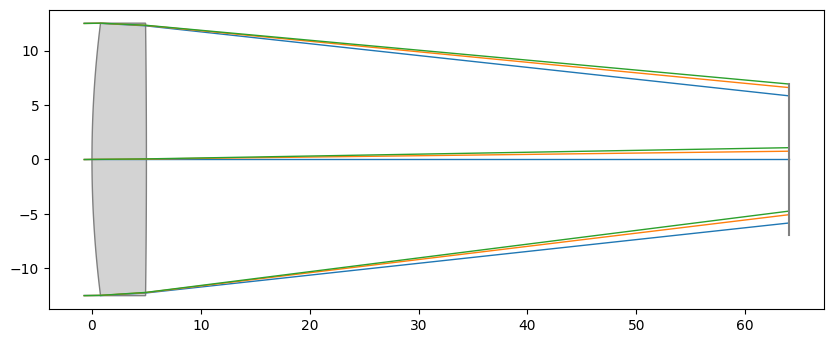

In [3]:
lens.draw()

Now, we need to define the optimization problem, which contains all information about the variables and operands.

In particular, we will optimize for minimal optical path difference for each field. We will also add an operand to specify the focal length at 100 mm. As for variables, we will let the lens radii vary and the distance from the lens to the image plane. Once defined, we can view all information related to the optimization problem using the 'info' method.

There are many operand types available, which can be seen in optiland.operand. Variable options can be seen in optiland.variable,

In [4]:
problem = optimization.OptimizationProblem()

for wave in lens.wavelengths.get_wavelengths():
    for field in lens.fields.get_field_coords():
        input_data = {'optic': lens, 'Hx': field[0], 'Hy': field[1], 'num_rays': 3, 'wavelength': wave, 'distribution': 'gaussian_quad'}
        problem.add_operand(operand_type='OPD_difference', target=0, weight=1, input_data=input_data)

problem.add_operand(operand_type='f2', target=100, weight=10, input_data={'optic': lens})

problem.add_variable(lens, 'thickness', surface_number=2, min_val=0, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=1, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=2, min_val=-1000, max_val=1000)

problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                 209255 |                 0 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+----------+----------+--------------------+
|    | Operand Type   |   Target |   Weight |    Value |    Delta |   Contribution (%) |
|----+----------------+----------+----------+----------+----------+--------------------|
|  0 | OPD difference |        0 |        1 | 253.838  | 253.838  |           30.792   |
|  1 | OPD difference |        0 |        1 |  84.6424 |  84.6424 |            3.42373 |
|  2 | OPD difference |        0 |        1 |  84.6783 |  84.6783 |            3.42664 |
|  3 | OPD difference |        0 |        1 | 216.741  | 216.741  |           22.4494  |
|  4 | OPD difference |        0 |        1 |  72.2768 |  72.2768 |            2.49645 |
|  5 | OPD difference |     

We now need to define an optimizer, which will take the optimization problem as an input. We choose a standard least squares optimizer.

In [5]:
optimizer = optimization.LeastSquares(problem)

We can now simply call the optimizer.

In [6]:
res = optimizer.optimize()

If we now view the optimization problem info, we can see that we've significantly improved the system (>99.9%)

In [7]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                102.609 |            99.951 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+-----------+------------+--------------------+
|    | Operand Type   |   Target |   Weight |     Value |      Delta |   Contribution (%) |
|----+----------------+----------+----------+-----------+------------+--------------------|
|  0 | OPD difference |        0 |        1 |   6.49255 | 6.49255    |        41.0816     |
|  1 | OPD difference |        0 |        1 |   2.18595 | 2.18595    |         4.65691    |
|  2 | OPD difference |        0 |        1 |   2.20861 | 2.20861    |         4.75393    |
|  3 | OPD difference |        0 |        1 |   3.13945 | 3.13945    |         9.60561    |
|  4 | OPD difference |        0 |        1 |   1.0285  | 1.0285     |         1.03091    |
|  5

And when we view the lens, we see that it properly focuses the light on our image plane.

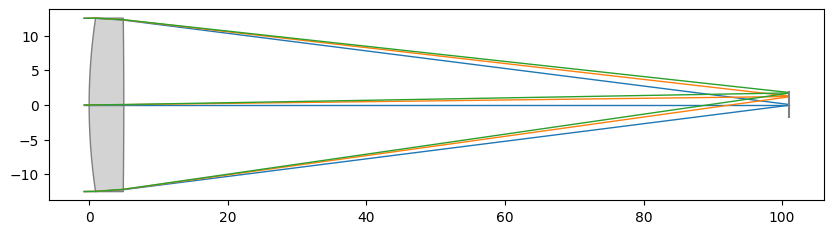

In [8]:
lens.draw()

Let's look at a few other common analyes:

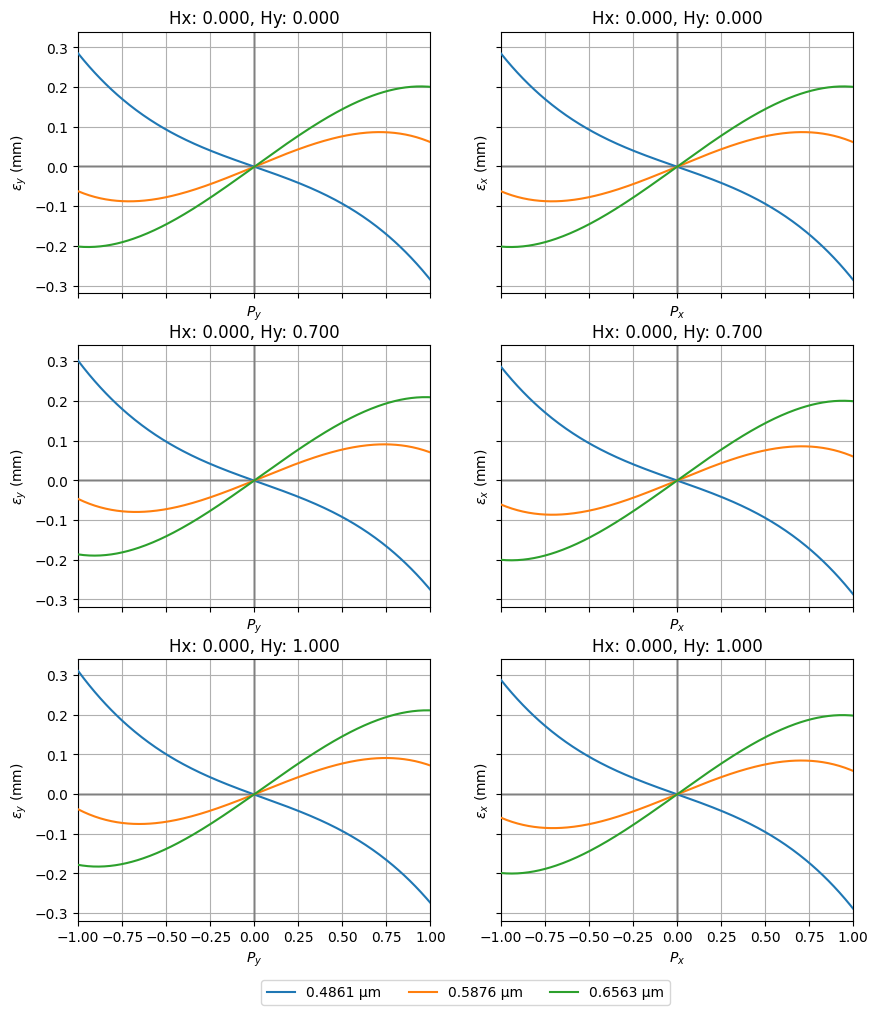

In [9]:
fan = analysis.RayFan(lens)
fan.view()

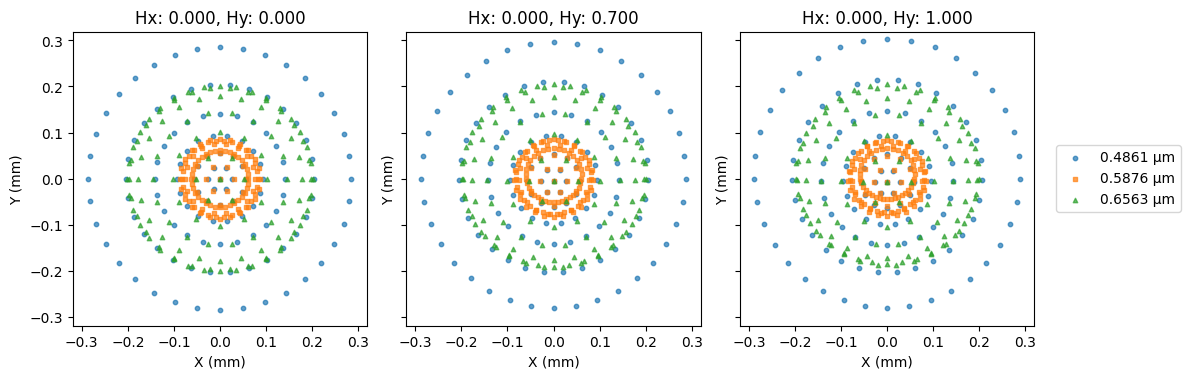

In [10]:
spot = analysis.SpotDiagram(lens)
spot.view()

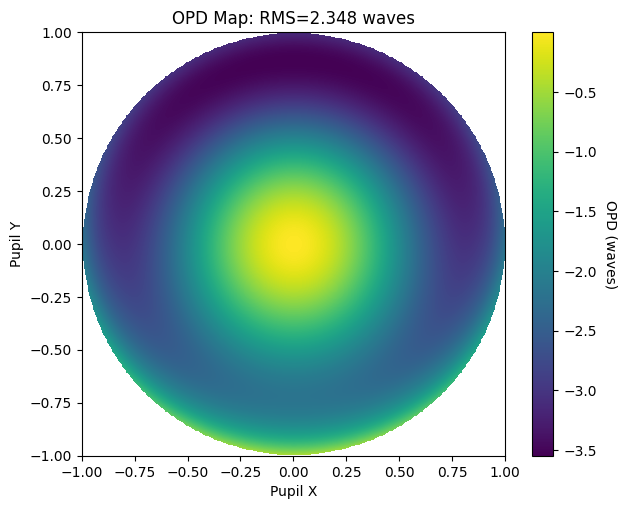

In [11]:
opd = wavefront.OPD(lens, field=(0, 1), wavelength=0.55)
opd.view(projection='2d', num_points=512)